# Top of notebook

In [1]:
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# %matplotlib widget
# %matplotlib inline
%matplotlib notebook

## Loading data and visualizations

The cell below loads a few npy files. They each have pose data from the original motinocapture files, however, **they are already
egocentered** such that the rat always looks to the right.

In [2]:
dnames = glob.glob('mocap_clean_eh5/*.npy')
egoh5s = []
for dname in dnames:
    egoh5s.append(np.load(dname, allow_pickle=True))
egoh5s = [eh5.reshape((eh5.shape[0], eh5.shape[1]//3, 3)) for eh5 in egoh5s]
temp = np.array(egoh5s)
print(temp.shape)

(1, 247197, 19, 3)


<IPython.core.display.Javascript object>


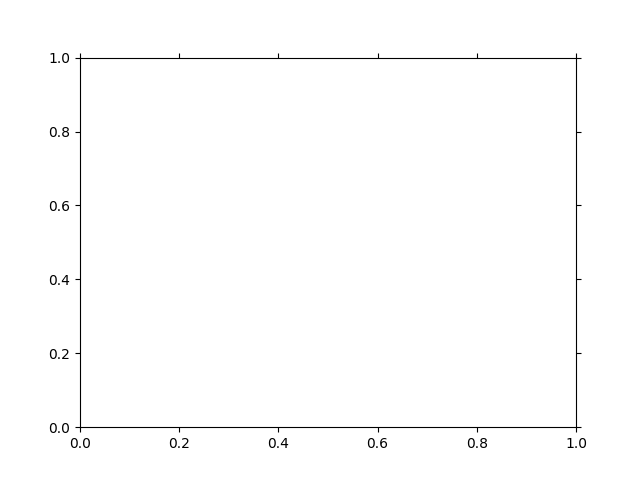

In [3]:
connections2 = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]

fig, ax = plt.subplots()

def animfunc(t, skip=1):
    ax.clear()
    lines = []
    for conn in connections2:
        conn = [3*i for i in conn]
        lines.append(ax.plot(egoh5s[0][t*skip, conn], egoh5s[0][t*skip, [i+1 for i in conn]])[0])
    ax.set_title('(%i, %i)'%((t, t*skip)))
    return lines,

anim = FuncAnimation(fig, animfunc, frames=20, fargs=(1000,), repeat=False)
        
# anim.event_source.stop()        

Let's plot the center of mass of these poses. If they are not very erronous, they should all lie in a clumb near origin. 

In [4]:
anim.event_source.stop()        

In [5]:
# np.argwhere(coms[:,0])

In [4]:
ax.get_xlim()

(0.0, 1.0)

(247197, 19, 3)
(247197, 3)
(247197,)


<IPython.core.display.Javascript object>


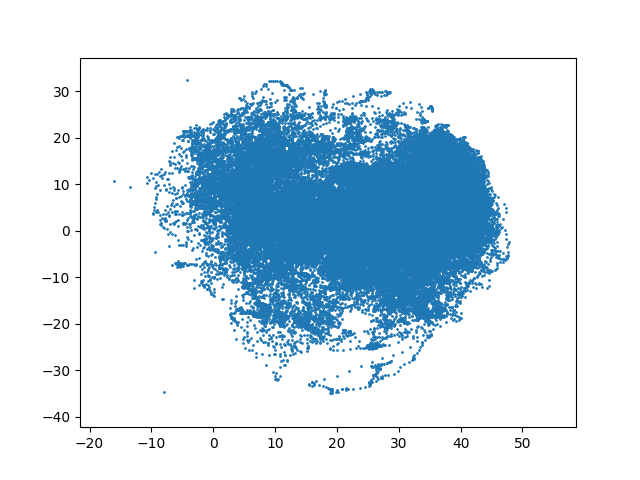

In [5]:
alleh5s = np.concatenate(egoh5s, axis=0)
print(alleh5s.shape)
# alleh5s = alleh5s.reshape((-1, alleh5s.shape[1]//3, 3))
alleh5s = alleh5s.reshape((-1, 19, 3))
coms = np.mean(alleh5s, axis=1)
print(coms.shape)
print(coms[:,0].shape)

fig, ax = plt.subplots()
ax.scatter(coms[:,0], coms[:,1], s=1)

Zoom in in the figure above to enclose only the central blob. Then run the cell below to select points that are in the central blob.

<IPython.core.display.Javascript object>


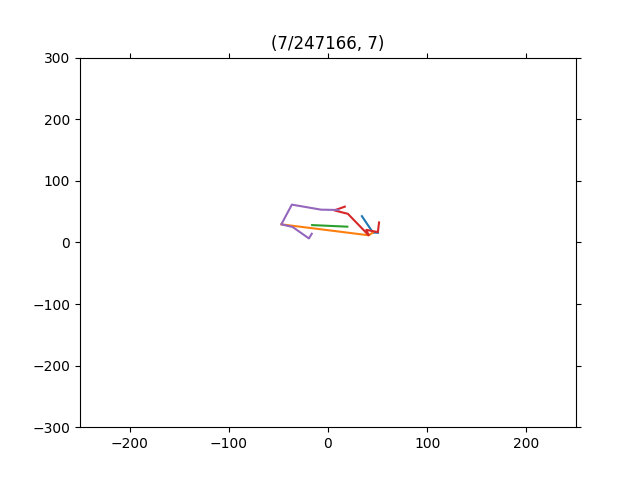

In [7]:
xlim, ylim = ax.get_xlim(), ax.get_ylim()

inds = np.where((coms[:,0]<xlim[1]) & (coms[:,0]>xlim[0]) & (coms[:,1]<ylim[1]) & (coms[:,1]>ylim[0]))[0]


connections2 = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]

fig2, ax2 = plt.subplots()

def animfunc(t):
    ax2.clear()
    lines = []
    for conn in connections2:        
        lines.append(ax2.plot(alleh5s[inds[t], conn, 0], alleh5s[inds[t], conn, 1])[0])
    ax2.set_title('(%i/%i, %i)'%((t, len(inds), inds[t])))
    ax2.set_xlim([-250, 250])
    ax2.set_ylim([-300, 300])
    return lines,

anim = FuncAnimation(fig2, animfunc, frames=len(inds), repeat=False)


In [8]:
anim.event_source.stop()

So not all poses have a center of mass at origin, so we don't have a very clean pose data to start with. 

In [9]:
alleh5s_clean = alleh5s[inds]

## Training AE model 

Before moving on to a variationa autoencoder, let's try to train a simple autoencode, and see if it is able to reconstruct poses with sufficiently low error. 
This also gives opportunity to change different parameters (activation functions, number of units) for the overall network architecture.

In [10]:
alleh5s_clean.shape[0]/alleh5s.shape[0]

0.9998745939473376

In [11]:
trainx = alleh5s_clean[::30].reshape((-1, 57)).astype('float32')
valx = alleh5s_clean[15::60].reshape((-1, 57)).astype('float32')
print(trainx.shape, valx.shape)
print(trainx.min(), trainx.max())

(8239, 57) (4120, 57)
-164.39641 128.8524


In [12]:
import tensorflow as tf
import tensorflow.keras as k
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [13]:
AE = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(57,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(8, activation=None),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(57, activation=None)])

AE.compile('adam', 'mse')

In [14]:
AE.fit(trainx, trainx, batch_size=64, epochs=50, validation_data=(valx, valx), callbacks = [tf.keras.callbacks.ModelCheckpoint(
    'MotionCapture_AE.h5', monitor="val_loss", verbose=1, save_best_only=True)])

Epoch 1/50
129/129 [==============================] - 2s 8ms/step - loss: 728.2623 - val_loss: 120.2887

Epoch 00001: val_loss improved from inf to 120.28870, saving model to MotionCapture_AE.h5
Epoch 2/50
129/129 [==============================] - 1s 6ms/step - loss: 80.9615 - val_loss: 59.8417

Epoch 00002: val_loss improved from 120.28870 to 59.84168, saving model to MotionCapture_AE.h5
Epoch 3/50
129/129 [==============================] - 1s 6ms/step - loss: 48.9284 - val_loss: 40.1793

Epoch 00003: val_loss improved from 59.84168 to 40.17929, saving model to MotionCapture_AE.h5
Epoch 4/50
129/129 [==============================] - 1s 6ms/step - loss: 33.6466 - val_loss: 27.5631

Epoch 00004: val_loss improved from 40.17929 to 27.56310, saving model to MotionCapture_AE.h5
Epoch 5/50
129/129 [==============================] - 1s 6ms/step - loss: 22.7479 - val_loss: 19.0047

Epoch 00005: val_loss improved from 27.56310 to 19.00466, saving model to MotionCapture_AE.h5
Epoch 6/50
129/1


Epoch 00043: val_loss improved from 7.24184 to 7.14359, saving model to MotionCapture_AE.h5
Epoch 44/50
129/129 [==============================] - 1s 5ms/step - loss: 7.0402 - val_loss: 7.0343

Epoch 00044: val_loss improved from 7.14359 to 7.03425, saving model to MotionCapture_AE.h5
Epoch 45/50
129/129 [==============================] - 1s 5ms/step - loss: 7.0559 - val_loss: 7.0210

Epoch 00045: val_loss improved from 7.03425 to 7.02098, saving model to MotionCapture_AE.h5
Epoch 46/50
129/129 [==============================] - 1s 7ms/step - loss: 6.9703 - val_loss: 6.9273

Epoch 00046: val_loss improved from 7.02098 to 6.92727, saving model to MotionCapture_AE.h5
Epoch 47/50
129/129 [==============================] - 1s 4ms/step - loss: 6.9238 - val_loss: 6.7976

Epoch 00047: val_loss improved from 6.92727 to 6.79757, saving model to MotionCapture_AE.h5
Epoch 48/50
129/129 [==============================] - 1s 5ms/step - loss: 6.8739 - val_loss: 6.8052

Epoch 00048: val_loss did not

#all data AE error 70

#clean data AE error 22



            tf.keras.layers.InputLayer(input_shape=(57,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(8, activation='sigmoid'), #24 with 'tanh' here #16 with None!!!
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(57, activation=None)])



#clean data AE error 61



            tf.keras.layers.InputLayer(input_shape=(57,)),
            tf.keras.layers.Dense(32, activation=None),
            tf.keras.layers.Dense(16, activation=None),
            tf.keras.layers.Dense(8, activation='tanh'),
            tf.keras.layers.Dense(16, activation=None),
            tf.keras.layers.Dense(32, activation=None),
            tf.keras.layers.Dense(57, activation=None)])



#clean data AE error 41 with wonky activations - 



            tf.keras.layers.InputLayer(input_shape=(57,)),
            tf.keras.layers.Dense(32, activation='sigmoid'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(8, activation='tanh'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(32, activation='sigmoid'),
            tf.keras.layers.Dense(57, activation=None)])



#clean data AE error 38 with wonky activations - 



            tf.keras.layers.InputLayer(input_shape=(57,)),
            tf.keras.layers.Dense(32, activation='tanh'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(8, activation='sigmoid'),
            tf.keras.layers.Dense(16, activation='tanh'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(57, activation=None)])



#clean data AE error 66 with  - 



            tf.keras.layers.InputLayer(input_shape=(57,)),
            tf.keras.layers.Dense(32, activation='sigmoid'),
            tf.keras.layers.Dense(16, activation='sigmoid'),
            tf.keras.layers.Dense(8, activation='sigmoid'),
            tf.keras.layers.Dense(16, activation='sigmoid'),
            tf.keras.layers.Dense(32, activation='sigmoid'),
            tf.keras.layers.Dense(57, activation=None)])


In [15]:
valx_pred = AE.predict(valx, verbose=1)

129/129 [==============================] - 1s 6ms/step


<IPython.core.display.Javascript object>


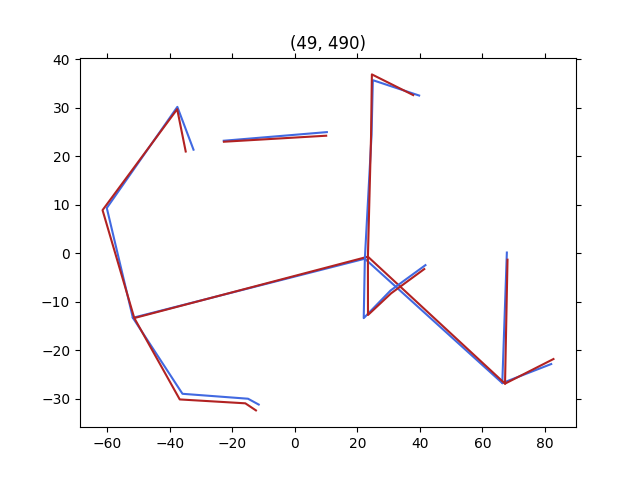

In [16]:
connections2 = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]

fig, ax = plt.subplots()

def animfunc(t, skip=1):
    ax.clear()
    lines = []
    for conn in connections2:
        conn = [3*i for i in conn]
        lines.append(ax.plot(valx[t*skip, conn], valx[t*skip, [i+1 for i in conn]], color='royalblue')[0])
        lines.append(ax.plot(valx_pred[t*skip, conn], valx_pred[t*skip, [i+1 for i in conn]], color='firebrick')[0])
    ax.set_title('(%i, %i)'%((t, t*skip)))
    return lines,

anim = FuncAnimation(fig, animfunc, frames=50, fargs=(10,), repeat=False)
        
#anim.event_source.stop()        

Seems like the errors in the validation set are very close to less than 3px. That is great, 
especially since we did not normalize our data in any way. 

In [ ]:
anim.event_source.stop()        

In [17]:
errors = np.abs(valx_pred-valx).reshape((-1, 19, 3))
np.mean(errors, axis=(0,1))

array([1.7861096, 1.5588305, 1.6629307], dtype=float32)

We can get the latent layer values by defining a new model with output from layer 2 of our autoencoder

In [18]:
AE.layers

In [19]:
AE2 = k.models.Model(inputs=AE.input, outputs=AE.layers[2].output)

In [20]:
#check if the weights are same 
[np.all(w1==w2) for w1,w2 in zip(AE.get_weights(),AE2.get_weights())]

[True, True, True, True, True, True]

In [21]:
alleh5s_clean_ae = AE2.predict(alleh5s_clean.reshape((-1, 57)).astype('float32'), verbose=1)
alleh5s_clean_ae.shape

7724/7724 [==============================] - 17s 2ms/step


(247166, 8)

## Training a VAE Model

Now that we have some idea of what network architecture works for our data, we can try to add the variational inference 
inside the network. 

In [22]:
class Sampling(k.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [23]:
class VAEModel(k.Model):
    def __init__(self, latent_dim=8, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.encoder = self.create_encoder()
        self.decoder = self.create_decoder()
        self.total_loss_tracker = k.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = k.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = k.metrics.Mean(name="kl_loss")

    def create_encoder(self):
        encoder_input = tf.keras.Sequential([
                    tf.keras.layers.InputLayer(input_shape=(57,)),
                    tf.keras.layers.Dense(32, activation='relu'),
                   tf.keras.layers.Dense(16, activation='relu'),])

        z_mean = k.layers.Dense(self.latent_dim, name="z_mean", activation='tanh')(encoder_input.output)
        z_log_var = k.layers.Dense(self.latent_dim, name="z_log_var", activation='tanh')(encoder_input.output)

        z = Sampling()([z_mean, z_log_var])
        encoder = k.Model(encoder_input.input, [z_mean, z_log_var, z], name="encoder")        
        return encoder
    
    def create_decoder(self):
        decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(self.latent_dim,)),
           tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(57)])
        return decoder

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                    k.losses.mean_squared_error(data, reconstruction))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return reconstruction

<IPython.core.display.Javascript object>


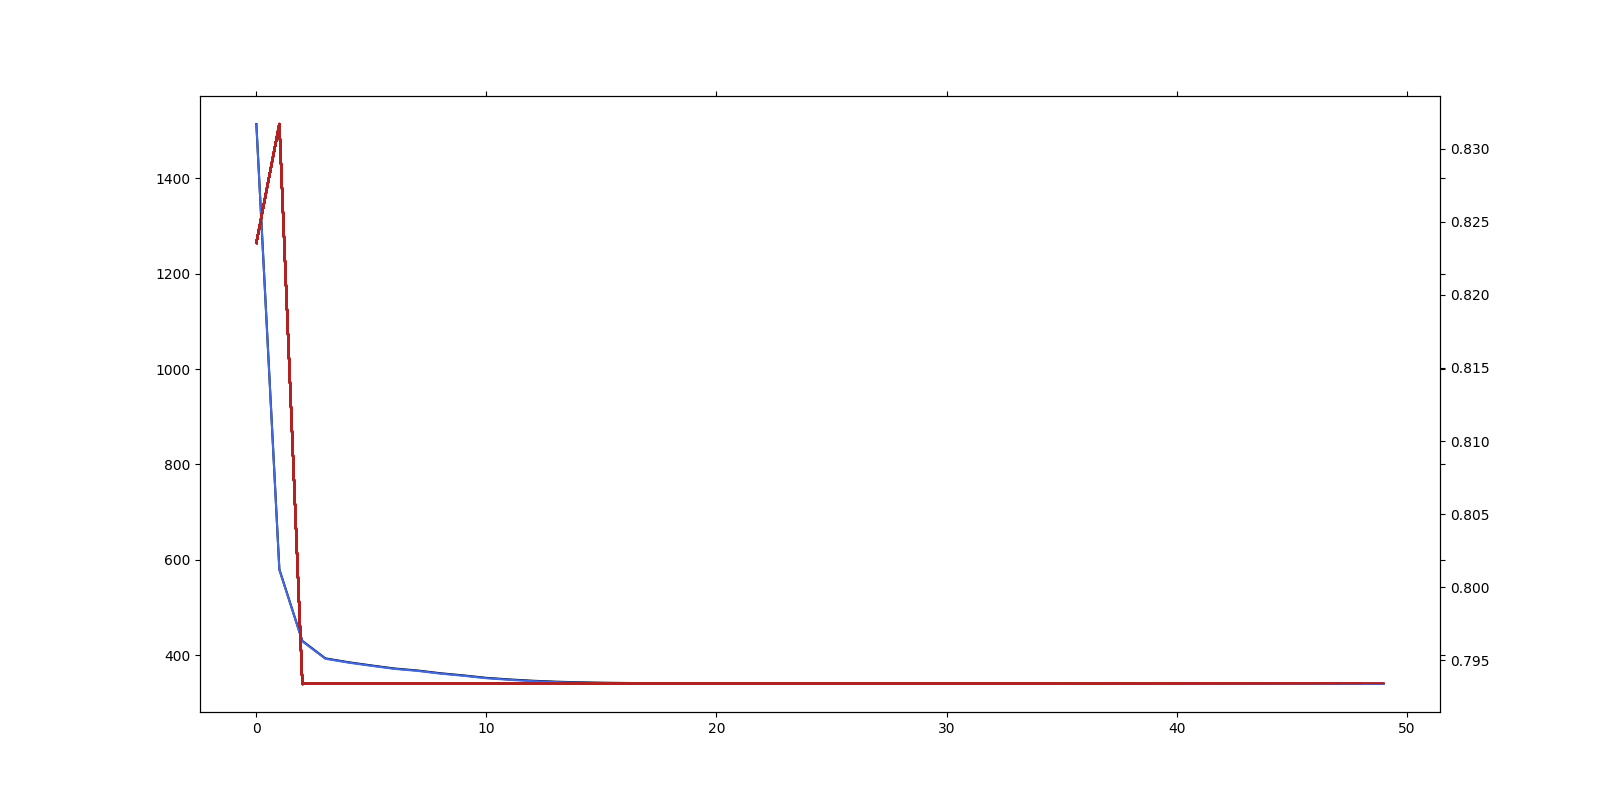

In [24]:
figloss, axloss = plt.subplots(figsize=(16, 8))
axloss2 = axloss.twinx()

class LossPlot(k.callbacks.Callback):
    def __init__(self):
        self.losses = [0,0,0]
        
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        self.losses = np.vstack([self.losses, [logs['loss'], logs['reconstruction_loss'], logs['kl_loss']]])
        axloss.clear()
        axloss.plot(self.losses[1:,0], '-', color='black', label='loss')
        axloss.plot(self.losses[1:,1], '-', color='royalblue', label='loss (recon)')
        axloss2.plot(self.losses[1:,2], '-', color='firebrick', label='loss (kl)')
        figloss.canvas.draw()

In [25]:
vae = VAEModel(latent_dim=8)
vae.compile(optimizer=k.optimizers.Adam(learning_rate=0.001))
vae.fit(trainx, epochs=50, batch_size=64, workers=1, callbacks=LossPlot())

Epoch 1/50
129/129 [==============================] - 2s 5ms/step - loss: 1716.6692 - reconstruction_loss: 1513.2085 - kl_loss: 0.8235
Epoch 2/50
129/129 [==============================] - 1s 6ms/step - loss: 670.3375 - reconstruction_loss: 578.8499 - kl_loss: 0.8317
Epoch 3/50
129/129 [==============================] - 1s 8ms/step - loss: 448.9697 - reconstruction_loss: 428.8121 - kl_loss: 0.7934
Epoch 4/50
129/129 [==============================] - 1s 6ms/step - loss: 394.4947 - reconstruction_loss: 392.2646 - kl_loss: 0.7934
Epoch 5/50
129/129 [==============================] - 1s 6ms/step - loss: 386.5901 - reconstruction_loss: 384.1677 - kl_loss: 0.7934
Epoch 6/50
129/129 [==============================] - 1s 7ms/step - loss: 378.5686 - reconstruction_loss: 377.4076 - kl_loss: 0.7934
Epoch 7/50
129/129 [==============================] - 1s 5ms/step - loss: 372.5199 - reconstruction_loss: 371.0037 - kl_loss: 0.7934
Epoch 8/50
129/129 [==============================] - 1s 10ms/step 

In [26]:
valx_pred_vae = vae.predict(valx, verbose=1)

129/129 [==============================] - 1s 3ms/step


<IPython.core.display.Javascript object>


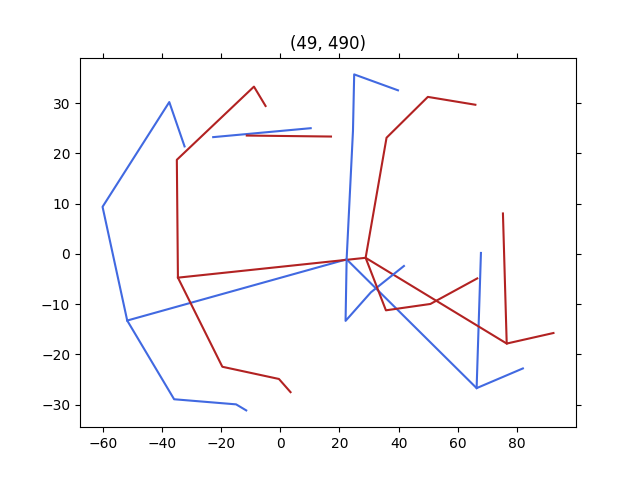

In [27]:
connections2 = [[5, 4, 6], [4,17,18], [11,12], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]

fig, ax = plt.subplots()

def animfunc(t, skip=1):
    ax.clear()
    lines = []
    for conn in connections2:
        conn = [3*i for i in conn]
        lines.append(ax.plot(valx[t*skip, conn], valx[t*skip, [i+1 for i in conn]], color='royalblue')[0])
        lines.append(ax.plot(valx_pred_vae[t*skip, conn], valx_pred_vae[t*skip, [i+1 for i in conn]], color='firebrick')[0])
    ax.set_title('(%i, %i)'%((t, t*skip)))
    return lines,

anim = FuncAnimation(fig, animfunc, frames=50, fargs=(10,), repeat=False)
        
#anim.event_source.stop()        

Seems like the errors in the validation set are around 7px (they were 3px w/ AE)

In [ ]:
errors = np.abs(valx_pred_vae-valx).reshape((-1, 19, 3))
np.mean(errors, axis=(0,1))

The latent layer values can be obtained using the VAE 'encoder' sub-model. 

In [ ]:
z_mean, z_log_var, z = vae.encoder.predict(alleh5s_clean.reshape((-1, 57)), verbose=1)

In [ ]:
print(z_mean.shape, z_log_var.shape, z.shape)